In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from scipy.ndimage import grey_dilation,grey_erosion

2024-10-22 12:32:00.526718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 12:32:00.531797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 12:32:00.594842: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 12:32:00.669735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 12:32:00.742150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
#vamos aprende ler uma colecao de figuras

#Listar arquivos .png na pasta atual
current_directory = os.getcwd()+"/figuras/"

event_files=[[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("event" in f) and ("nue" in f) and ("plane_"+str(i) in f)
                                                           )]
              for i in range(3)]
for i in range(3):
    event_files[i]=sorted(event_files[i])

hit_files=[[f for f in os.listdir(current_directory) if (f.endswith('.png') and ("hit" in f) and ("nue" in f) and ("plane_"+str(i) in f)
                                                         )]
              for i in range(3)]
for i in range(3):
    hit_files[i]=sorted(hit_files[i])

In [4]:
len(hit_files[1])

5187

In [5]:
#selecionando figuras aleatorias
n_total=len(event_files[0])
n_figuras=3000

random=np.random.choice(n_total,n_figuras,replace=False)

x=[[] for _ in range(n_figuras)]
y=[[] for _ in range(n_figuras)]

x_end=144 # <--271
y_end=304 # <--610 

structure = np.ones((3, 3), dtype=np.uint8)  # Elemento estruturante 3x3

for j in range(n_figuras):
    for index in range(3):
        x[j].append(np.divide(grey_dilation(np.array(Image.open(current_directory+event_files[index][random[j]]).convert('L'), dtype=np.uint8),footprint=structure),215))
        y[j].append(np.divide(grey_dilation(np.array(Image.open(current_directory+hit_files[index][random[j]]).convert('L')),footprint=structure),215))

In [6]:
#deixando a saida binaria
for j in range(n_figuras):
    for i in range(3):
        y[j][i][(y[j][i] > 0.7)] = 1
        y[j][i][~((y[j][i] > 0.7) )] = 0 

In [11]:
#arrumando as dimennsoes da terceira imagem

from scipy.ndimage import zoom
from scipy.ndimage import generic_filter
def media(arr):
    return np.mean(arr)

for j in range(n_figuras):
    for index in range(3):
        x[j][index]=zoom(x[j][index],(x_end/len(x[j][index]),y_end/len(x[j][index][0])))
        y[j][index]=zoom(y[j][index],(x_end/len(y[j][index]),y_end/len(y[j][index][0])))

tamanho_janela = 3  # Tamanho da janela (deve ser ímpar)3
value=0.65

#deixando a saida binaria
for j in range(n_figuras):
    for index in range(3):
        y[j][index][(y[j][index] > 0.5)] = 1
        y[j][index][~((y[j][index] > 0.5) )] = 0 
        y[j][index] = generic_filter(y[j][index], media, size=tamanho_janela)
        y[j][index][(y[j][index] >value )] = 1
        y[j][index][~((y[j][index] >value) )] = 0 

for j in range(n_figuras):
    for index in range(3):
        x[j][index][~((x[j][index] > 0.25) )] = 0 

x = np.transpose(x, (0, 2, 3, 1))
y = np.transpose(y, (0, 2, 3, 1))



In [12]:
#separando em treino e teste dados

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)
y=[]
x=[]
#x_train,x_test,y_train,y_test = train_test_split(x,x_teste,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=np.array(y_train)
y_test=np.array(y_test)


In [13]:
x_train = x_train.reshape((-1,x_end,y_end,3))
x_test = x_test.reshape((-1,x_end,y_end,3))
y_train = y_train.reshape((-1,x_end,y_end,3))
y_test = y_test.reshape((-1,x_end,y_end,3))

In [275]:

encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), kernel_initializer="he_normal", padding='same', input_shape=(x_end, y_end, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
])

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, (3, 3), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), kernel_initializer="he_normal", padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), kernel_initializer="he_normal", padding='same'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.UpSampling2D((2, 2)), 
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', kernel_initializer="he_normal", padding='same')
])

autoencoder2 = tf.keras.Sequential([encoder, decoder])

/home/gabriel/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
autoencoder2.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [10]:
autoencoder2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 18, 38, 256)    │       375,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 144, 304, 3)    │     1,486,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,862,147 (7.10 MB)

 Trainable params: 1,860,483 (7.10 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [60]:
x_hist=[]
total=x_end*y_end
for i in range(len(y_train)):
    for j in range(3):
        sum=np.sum(y_train[i,:,:,j])
        x_hist.append((total-sum)/sum)

/tmp/ipykernel_237419/1190276901.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  x_hist.append((total-sum)/sum)


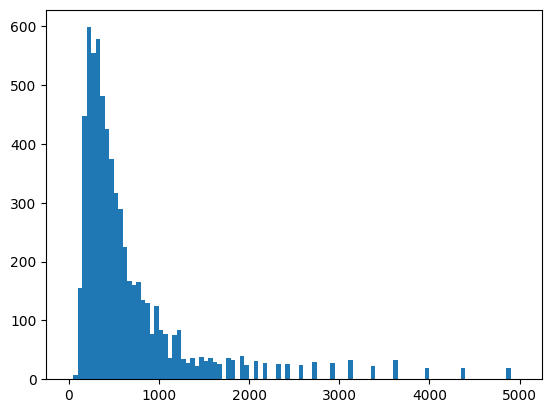

In [66]:
plt.hist(x_hist,bins=100,range=[0,5000])
plt.show()

In [28]:
history = autoencoder2.fit(x_train,x_train, epochs=10, batch_size=30, validation_data=[x_test,x_test])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 474s 9s/step - loss: 0.0712 - val_loss: 0.0582
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 439s 9s/step - loss: 0.0388 - val_loss: 0.0381
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 438s 9s/step - loss: 0.0382 - val_loss: 0.0364
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 436s 9s/step - loss: 0.0368 - val_loss: 0.0362
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 433s 9s/step - loss: 0.0366 - val_loss: 0.0360
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 435s 9s/step - loss: 0.0362 - val_loss: 0.0361
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 435s 9s/step - loss: 0.0361 - val_loss: 0.0360
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 435s 9s/step - loss: 0.0361 - val_loss: 0.0358
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 432s 9s/step - loss: 0.0360 - val_loss: 0.0359
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 432s 9s/step - loss: 0.0354 - val_loss: 0.0355


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


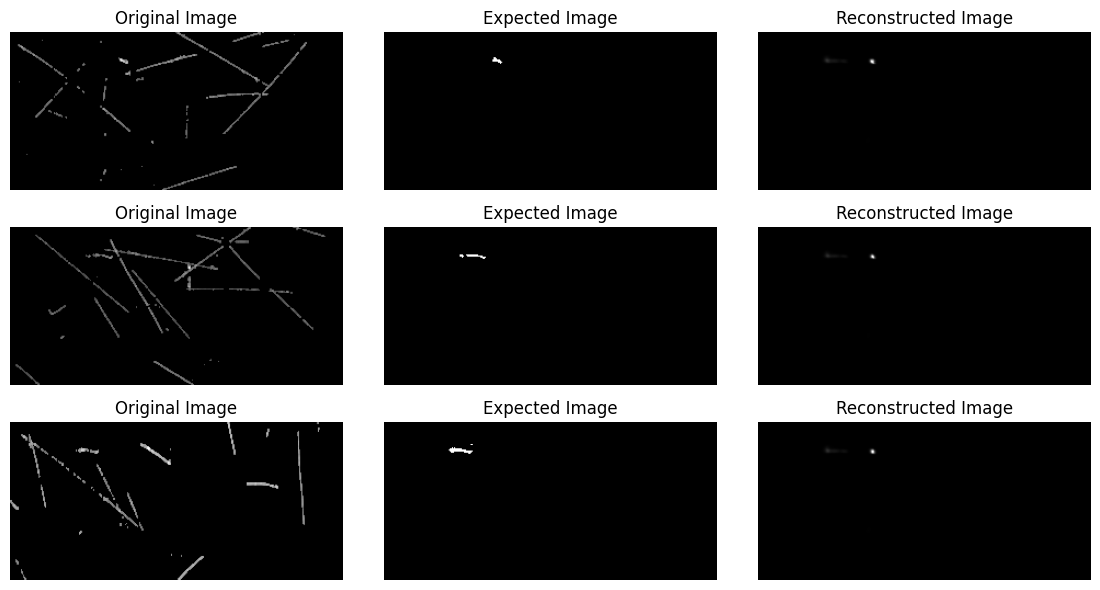

In [74]:
#printa imagem original, imagem recuperada e imagem esperada

index=5

prediction=autoencoder2.predict(x_test[index].reshape(1,x_end,y_end,3))
plt.figure(figsize=(12, 6))

for j in range(3):
    # Exibir a imagem original
    plt.subplot(3, 3, j*3+1)
    plt.imshow(x_test[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Original Image')
    plt.axis('off')  # Desliga os eixos
    plt.tight_layout()

    #Exibir Imagem esperada
    plt.subplot(3, 3, j*3+2)
    plt.imshow(y_test[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Expected Image')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()

    plt.subplot(3, 3 ,j*3+3)
    plt.imshow(prediction[0,:,:,j], cmap='gray')  # Adapte o cmap se necessário
    plt.title('Reconstructed Image')
    plt.axis('off')  # Desliga os eixos
    # Mostrar as imagens
    plt.tight_layout()

plt.show()


In [14]:
#autoencoder2.save('this_neutrino_autoencoder_3_figures.h5')

In [67]:
def weighted_binary_crossentropy(y_true, y_pred, weight_0=1., weight_1=200.):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calcula a perda binária ponderada
    loss = - (weight_1 * y_true * tf.math.log(y_pred + tf.keras.backend.epsilon()) + 
              weight_0 * (1 - y_true) * tf.math.log(1 - y_pred + tf.keras.backend.epsilon()))

    return tf.reduce_mean(loss)  # Retorna a média das perdas


def combined_loss(y_true, y_pred, weight_0=1., weight_1=200.):
    # Calcula a perda para todos os canais e tira a média
    losses = tf.stack([weighted_binary_crossentropy(y_true[..., i], y_pred[..., i], weight_0, weight_1) 
                        for i in range(y_true.shape[-1])])  # Cria uma pilha das perdas

    return tf.reduce_mean(losses)  # Retorna a média das perdas dos canais




" autoencoder2.compile(\n    loss='binary_crossentropy',\n    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n) "

In [53]:
autoencoder2.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=combined_loss)

""" autoencoder2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
) """
autoencoder2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 144, 304, 3)    │     3,467,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 144, 304, 3)    │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,468,063 (13.23 MB)

 Trainable params: 3,465,071 (13.22 MB)

 Non-trainable params: 2,992 (11.69 KB)

In [ ]:
for j in range(10):
    history = autoencoder2.fit(x_train, y_train, epochs=10, batch_size=30, validation_data=(x_test, y_test))
    autoencoder2.save("this_neutrino_autoencoder_3_figures_agorasim_7_" + str(j) + ".h5")


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 818s 11s/step - loss: 0.4700 - val_loss: 0.7217
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 785s 10s/step - loss: 0.4508 - val_loss: 0.7052
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 780s 10s/step - loss: 0.4302 - val_loss: 0.7246
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 796s 11s/step - loss: 0.4140 - val_loss: 0.7035
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 746s 10s/step - loss: 0.3960 - val_loss: 0.6984
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 824s 11s/step - loss: 0.3820 - val_loss: 0.6681
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 814s 11s/step - loss: 0.3657 - val_loss: 0.6834
Epoch 8/10
65/75 ━━━━━━━━━━━━━━━━━━━━ 1:36 10s/step - loss: 0.3527

In [29]:
#plotando histograma da previsao e do valor real
y_pred_prob = autoencoder2.predict(x_test) 

24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


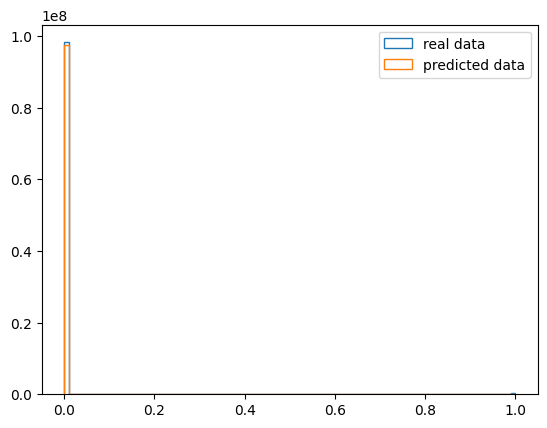

In [30]:
plt.hist(y_test.flatten(), bins=100, fill=False, histtype='step', label="real data")
plt.hist(y_pred_prob.flatten(),bins=100, fill=False, histtype='step', label="predicted data")
plt.legend()

plt.show()

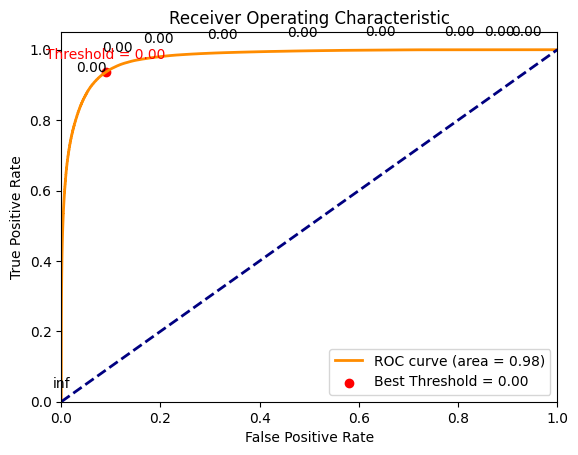

In [31]:
#vamos plotar os graficos classicos 

from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.flatten(), y_pred_prob.flatten())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

#best threshold
J = tpr - fpr
best_threshold_index = np.argmax(J)
best_threshold = thresholds[best_threshold_index]

# Annotate some thresholds on the ROC curve
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the best threshold point
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.annotate(f'Threshold = {best_threshold:.2f}', 
             (fpr[best_threshold_index], tpr[best_threshold_index]), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center', 
             color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#salvar figuras
#printa imagem original, imagem recuperada e imagem esperada

#prediction=autoencoder2.predict(x_test[index].reshape(1,x_end,y_end,3))
plt.figure(figsize=(12, 12))
for index in range(len(x_test)):

    predict=autoencoder2.predict(np.reshape(x_test[index],(1,x_end,y_end,3)))
    predict_cut=np.copy(predict)
    for j in range(3):
        predict_cut[0,:,:,j][(predict_cut[0,:,:,j] > best_threshold)] = 1
        predict_cut[0,:,:,j][~((predict_cut[0,:,:,j] > best_threshold) )] = 0 


    for j in range(3):
        # Exibir a imagem original
        filename=os.path.splitext(event_files[0][index])[0]

        plt.subplot(3, 4, j*4+1)
        plt.imshow(x_test[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Original Image')
        plt.axis('off')  # Desliga os eixos
        plt.tight_layout()

        #Exibir Imagem esperada
        plt.subplot(3, 4, j*4+2)
        plt.imshow(y_test[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Expected Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()


        plt.subplot(3, 4 ,j*4+3)
        plt.imshow(predict[0,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Reconstructed Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()

        plt.subplot(3, 4 ,j*4+4)
        plt.imshow(predict_cut[0,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Cut Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()

    plt.savefig(f"./results_3/"+filename+"_test.png",  bbox_inches='tight', pad_inches=0)
    plt.clf()  # Limpa a figura para a próxima imagem

In [1]:
autoencoder2 = tf.keras.models.load_model('this_neutrino_autoencoder_3_figures_agorasim_6_6.h5', custom_objects={'combined_loss': combined_loss})

NameError: name 'tf' is not defined

In [55]:
autoencoder2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 9, 19, 300)     │     1,068,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 144, 304, 3)    │     2,399,599 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,467,981 (13.23 MB)

 Trainable params: 3,464,987 (13.22 MB)

 Non-trainable params: 2,992 (11.69 KB)

 Optimizer params: 2 (12.00 B)

In [56]:
final_layer=tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', kernel_initializer="he_normal", padding='same')
])

autoencoder2 = tf.keras.Sequential([autoencoder2, final_layer])
autoencoder2.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=combined_loss)

In [32]:
best_threshold

1.131812e-06

In [ ]:
#predite os dados de treino
y_pred_prob_all = autoencoder2.predict(x) # Compute ROC curve and ROC area

In [ ]:
#vamos plotar os graficos classicos 

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y.flatten(), y_pred_prob_all.flatten())
roc_auc = auc(fpr, tpr)


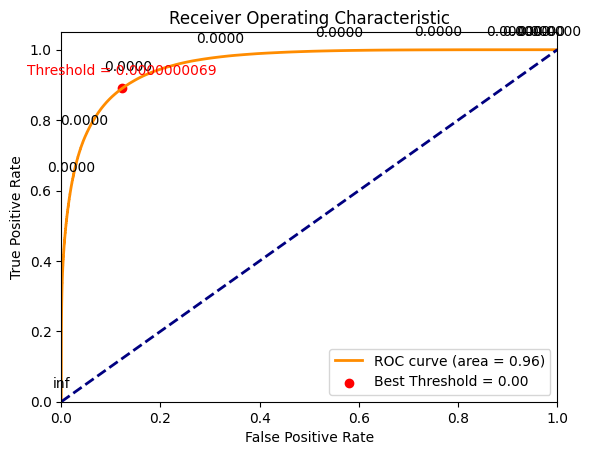

In [13]:

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

#best threshold
J = tpr - fpr
best_threshold_index = np.argmax(J)
best_threshold = thresholds[best_threshold_index]

# Annotate some thresholds on the ROC curve
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'{thresholds[i]:.4f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the best threshold point
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.annotate(f'Threshold = {best_threshold:.10f}', 
             (fpr[best_threshold_index], tpr[best_threshold_index]), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center', 
             color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [14]:
best_threshold

6.8860397e-09

In [88]:
#deixando a saida binaria

y_pred_prob_all_cut=np.copy(y_pred_prob_all)
#best_threshold=7e-4
for j in range(n_figuras):
    for index in range(3):
        y_pred_prob_all_cut[j,:,:,index][(y_pred_prob_all[j,:,:,index] > best_threshold)] = 1
        y_pred_prob_all_cut[j,:,:,index][~((y_pred_prob_all[j,:,:,index] > best_threshold) )] = 0 


In [1]:
best_threshold=2.2723487e-08

In [15]:
#salvar figuras
#printa imagem original, imagem recuperada e imagem esperada

#prediction=autoencoder2.predict(x_test[index].reshape(1,x_end,y_end,3))
plt.figure(figsize=(12, 12))
for index in range(len(x)):

    predict=autoencoder2.predict(np.reshape(x[index],(1,x_end,y_end,3)))
    predict_cut=np.copy(predict)
    for j in range(3):
        predict_cut[0,:,:,j][(predict_cut[0,:,:,j] > best_threshold)] = 1
        predict_cut[0,:,:,j][~((predict_cut[0,:,:,j] > best_threshold) )] = 0 


    for j in range(3):
        # Exibir a imagem original
        filename=os.path.splitext(event_files[0][index])[0]

        plt.subplot(3, 4, j*4+1)
        plt.imshow(x[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Original Image')
        plt.axis('off')  # Desliga os eixos
        plt.tight_layout()

        #Exibir Imagem esperada
        plt.subplot(3, 4, j*4+2)
        plt.imshow(y[index,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Expected Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()


        plt.subplot(3, 4 ,j*4+3)
        plt.imshow(predict[0,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Reconstructed Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()


       

        plt.subplot(3, 4 ,j*4+4)
        plt.imshow(predict_cut[0,:,:,j], cmap='gray')  # Adapte o cmap se necessário
        plt.title('Cut Image')
        plt.axis('off')  # Desliga os eixos
        # Mostrar as imagens
        plt.tight_layout()

    plt.savefig(f"./results_3/"+filename+".png",  bbox_inches='tight', pad_inches=0)
    plt.clf()  # Limpa a figura para a próxima imagem


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

In [ ]:
#predite os dados de treino
y_pred_prob_2 = autoencoder2.predict(x_train) # Compute ROC curve and ROC area

47/47 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step


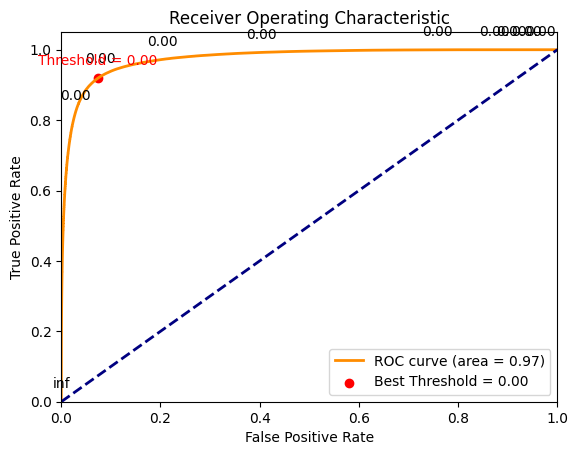

In [47]:
#vamos plotar os graficos classicos 

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train.flatten(), y_pred_prob_2.flatten())
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

#best threshold
J = tpr - fpr
best_threshold_index = np.argmax(J)
best_threshold = thresholds[best_threshold_index]

# Annotate some thresholds on the ROC curve
for i in range(0, len(thresholds), len(thresholds) // 10):
    plt.annotate(f'{thresholds[i]:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Highlight the best threshold point
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.annotate(f'Threshold = {best_threshold:.2f}', 
             (fpr[best_threshold_index], tpr[best_threshold_index]), 
             textcoords="offset points", 
             xytext=(0,10), 
             ha='center', 
             color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [50]:
best_threshold

1.8599488e-06